# Parcial 1: Reconstrucción 3D en Visión Computacional
##### Por: Elissa Castellanos y Mythili Kasibhatla

In [4]:
#Importamos las librerías necesarias para el desarollo del trabajo
import cv2  # Librería de visión por computadora
import numpy as np  # Librería para manejar arreglos numéricos y operaciones matemáticas
import os  # Librería para interactuar con el sistema operativo
import open3d as o3d  # Librería para trabajar con nubes de puntos y modelos 3D
import matplotlib.pyplot as plt  # Librería para visualización de gráficos e imágenes

#### 1. Calibración de la cámara

Antes de realizar la reconstrucción 3D con Structure from Motion (SfM), es necesario calibrar la cámara para obtener sus parámetros intrínsecos y corregir cualquier distorsión óptica en las imágenes. 

Para realizar esto utilizamos la calibración de la cámara que realizamos en el trabajo pasado de ChessBoard Calibration, donde tomamos fotos de un patrón de ajedrez, utilizamos OpenCV para identificar las esquinas y con esta información ejecutamos la función cv2.calibrateCamera() para obtener:
- Matriz de la cámara K (Parámetros intrínsecos)
- Coeficientes de distorción (Para corregir deformaciónes ópticas dadas por errores de la cámara utilizada)
- Vectores de rotación y traslación (Parámetros extrínsicos)

El código que utilizamos es el siguiente:

In [5]:
# Parámetros del tablero de ajedrez 
chessboard_size = (7,7) #Con esta linea determinamos el tamaño del tablero de ajedrez de la foto
#Definimos el numero de esquinas internas que tiene el tablero para que luego la función de OpenCV nos permita identificarlas en la imagen.

#Creamos una matriz del la cantidad de filas de los puntos interiores del tablero y con 3 columnas para representar el espacio de las coordenadas del mundo real, asumiendo que z = 0
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2) 
#Generamos dos matrices, una de las coordenadas x de los puntos en la cuadricula y otra de las coordenadas y de los puntos en la cuadrícula

# Listas para almacenar puntos 3D y puntos 2D
objpoints = []  # Puntos en el mundo real (3D)
imgpoints = []  # Puntos en la imagen (2D)

# Aquí cargamos todas las imagenes que tomamos del tablero en diferentes orientaciones pero misma distancia.
images = [
    "imagenes\img_chessboard\chessboard1.jpeg",
    "imagenes\img_chessboard\chessboard2.jpeg",
    "imagenes\img_chessboard\chessboard3.jpeg",
    "imagenes\img_chessboard\chessboard4.jpeg",
    "imagenes\img_chessboard\chessboard5.jpeg",
    "imagenes\img_chessboard\chessboard6.jpeg",
    "imagenes\img_chessboard\chessboard7.jpeg",
    "imagenes\img_chessboard\chessboard8.jpeg",
]

for fname in images:
    img = cv2.imread(fname) #Leemos la imagen
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #La pasamos a blanco y negro porque esto permite identificar los bordes.

    # Detectamos las esquinas usando findChessboardCorners que recibe como parámetros la imagen y el tamaño del tablero
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size)
    #La fución nos retorna:
        #ret: Un booleano que nos dice si se lograron identificar los bordes o no
        #corners: Un array de coordenadas de las esquinas detectadas en la imagen. Contiene la posición de una esquina en pixeles
    if ret:
        objpoints.append(objp)  #Guarda la matriz de las coordenadas del mundo real que es la misma independientemente de la foto
        imgpoints.append(corners)  # Guardar puntos 2D encontrados por la función cv2.findChessboardCorners() para esa imagen especifica


# Calibrar la cámara usando la función cv2.calibrateCamara() que recibe los puntos en 2d y 3d y las dimensiones de la imagen
ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#Esta función nos devuelve varios valores:
    #ret: Valor booleano que nos dice si la calibración fue exitosa o no
    #camara_matrix: La matriz de la cámara (lo que nos interesa para este ejercicio - Parámetro intrínseco  de la cámara)
    #dist_coeffs: Los coefficientes de distorción del lente (otro parametro intrínseco de la cámara)
    #rvecs: Los vectores de rotación (Parámetro extrínseco de la cámara)
    #tvecs: Los vectores de traslación (Parámetro extrínseco de la cámara)

# Mostrar los resultados de la matriz de la cámara
print("Matriz de la cámara:\n", camera_matrix)
print("Coeficientes de distorción:\n", dist_coeffs)

Matriz de la cámara:
 [[1.15515397e+03 0.00000000e+00 6.04485347e+02]
 [0.00000000e+00 1.15588485e+03 8.57394205e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Coeficientes de distorción:
 [[ 0.03288989  0.00788371  0.02962758  0.00369818 -2.34955104]]


#### 2. Preprocesamiento de imagenes
Una vez capturadas las imágenes, es necesario prepararlas para la detección de características. Por lo tanto las convertimos a escala de grises. Esto es útil porque elimina la información de color, reduciendo la cantidad de datos a procesar y mejorando la eficiencia de los algoritmos de detección de características. Además, algunos detectores de características están diseñados para trabajar con imágenes en escala de grises, lo que permite una mejor extracción de puntos clave.

In [6]:
# Definir la carpeta donde se encuentran las imágenes
image_folder = "imagenes\img_aguila"

# Obtener la lista de archivos de imagen en la carpeta y ordenarlos alfabéticamente
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))])

# Cargar imágenes en escala de grises desde la carpeta especificada
images = [cv2.imread(os.path.join(image_folder, fname), cv2.IMREAD_GRAYSCALE) for fname in image_files]


#### 3. Detección de características y emparejamiento de puntos

Ahora que tenemos las imágenes corregidas, el siguiente paso es detectar puntos clave en cada imagen y emparejarlos entre diferentes vistas. Esto es fundamental para Structure from Motion (SfM), ya que estos puntos nos permitirán estimar la posición relativa de las cámaras y reconstruir la estructura 3D de la escena. Para este paso utilizamos los siguientes algoritmos:
- SIFT (Scale-Invariant Feature Transform): Lo utilizamos para la detección de características porque es un método robusto a cambios de escala, iluminación y rotación. Esto significa que los puntos clave extraídos serán consistentes incluso si la imagen cambia de tamaño o está ligeramente iluminada de manera diferente.
- FLANN-Based Matcher (Fast Library for Approximate Nearest Neighbors): Lo usamos parav la correspondencia de puntos. FLANN es una buena opción porque permite encontrar correspondencias entre los puntos clave de manera eficiente, incluso cuando se manejan grandes volúmenes de datos. Utiliza estructuras de búsqueda óptimas para acelerar el emparejamiento de características.

Imagen 0: 3224 características detectadas
Imagen 1: 4859 características detectadas
Imagen 2: 1874 características detectadas
Imagen 3: 4928 características detectadas
Imagen 4: 3136 características detectadas
Imagen 5: 2773 características detectadas
Imagen 6: 3124 características detectadas
Imagen 7: 2484 características detectadas
Imagen 8: 3605 características detectadas
Imagen 9: 3046 características detectadas
Imagen 10: 1812 características detectadas
Imagen 11: 2593 características detectadas
Imagen 12: 3230 características detectadas


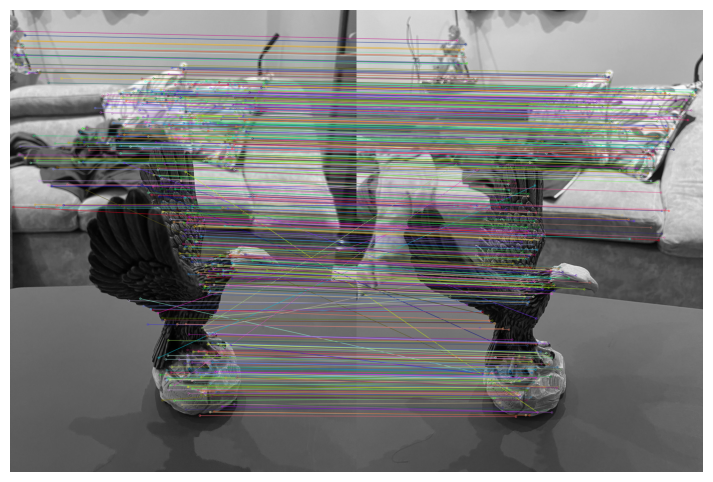

In [7]:
# Crear detector SIFT con un máximo de 8000 características detectadas
sift = cv2.SIFT_create(nfeatures=8000)

# Listas para almacenar puntos clave y descriptores
keypoints_list = []  # Lista de puntos clave detectados en cada imagen
descriptors_list = []  # Lista de descriptores correspondientes a cada punto clave

# Detectar características en cada imagen y calcular sus descriptores
for gray in images:
    keypoints, descriptors = sift.detectAndCompute(gray, None)  # Detecta los puntos clave y extrae los descriptores
    keypoints_list.append(keypoints)  # Almacena los puntos clave
    descriptors_list.append(descriptors)  # Almacena los descriptores

# Verificar cuántas características se detectaron en cada imagen
for i, keypoints in enumerate(keypoints_list):
    print(f"Imagen {i}: {len(keypoints)} características detectadas")

# Emparejamiento de características utilizando el algoritmo FLANN
# FLANN (Fast Library for Approximate Nearest Neighbors) es eficiente para encontrar coincidencias entre descriptores
matcher = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
matches_list = []  # Lista para almacenar los emparejamientos entre imágenes

#Guardar solo los emparejamientos válidos
for i in range(len(descriptors_list) - 1):
    matches = matcher.knnMatch(descriptors_list[i], descriptors_list[i + 1], k=2)  # Busca los dos mejores emparejamientos
    
    # Aplicar el ratio test de Lowe para filtrar emparejamientos correctos
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
    
    # Filtrar emparejamientos inválidos asegurando que los índices sean válidos
    num_keypoints_img1 = len(keypoints_list[i])
    num_keypoints_img2 = len(keypoints_list[i + 1])
    valid_matches = [m for m in good_matches if m.queryIdx < num_keypoints_img1 and m.trainIdx < num_keypoints_img2]
    
    matches_list.append(valid_matches)  # Almacenar los emparejamientos válidos

# Dibujar y mostrar emparejamientos entre dos imágenes seleccionadas
# Se elige una imagen intermedia para visualizar los emparejamientos
img_matches = cv2.drawMatches(
    images[7], keypoints_list[7],  # Imagen base y sus puntos clave
    images[8], keypoints_list[8],  # Imagen siguiente y sus puntos clave
    matches_list[7], None,  # Lista de emparejamientos
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS  # No dibujar puntos clave sin emparejamiento
)

# Mostrar la imagen con emparejamientos dentro del notebook
plt.figure(figsize=(12, 6)) 
plt.imshow(img_matches, cmap='gray')
plt.axis('off')
plt.show()



#### 4. Estimación de la matriz fundamental y la matriz escencial

Con los puntos clave emparejados, se procede a calcular:

Matriz Fundamental: Se estima usando el método RANSAC, filtrando correspondencias erróneas y obteniendo una relación geométrica entre dos imágenes. La matriz fundamental nos permite conocer las restricciones geométricas entre dos vistas y es clave para calcular la estructura 3D de la escena.

Matriz Esencial: Se deriva de la matriz fundamental e incorpora información sobre los parámetros intrínsecos de la cámara. Su importancia radica en que permite calcular la posición relativa de las cámaras, es decir, cómo se han movido en el espacio tridimensional, lo cual es crucial para la reconstrucción 3D.


In [8]:

# Extraer coordenadas de los puntos emparejados
pts1 = np.float32([keypoints_list[0][m.queryIdx].pt for m in good_matches])
pts2 = np.float32([keypoints_list[1][m.trainIdx].pt for m in good_matches])

# Calcular la Matriz Fundamental usando RANSAC
# findFundamentalMat() encuentra la matriz fundamental que relaciona puntos correspondientes en dos imágenes.
# Utiliza el método RANSAC para eliminar outliers y garantizar una mejor precisión.
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Calcular la Matriz Esencial
K = camera_matrix  # Matriz de la cámara previamente definida
E = K.T @ F @ K  # Matriz Esencial

# Descomponer la Matriz Esencial en Rotación y Traslación
# recoverPose() descompone la matriz esencial en una matriz de rotación (R) y un vector de traslación (t),
# lo que permite estimar el movimiento relativo de la cámara entre dos imágenes.
_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)

# Mostrar resultados
print("Matriz Fundamental (F):\n", F)
print("\nMatriz Esencial (E):\n", E)
print("\nRotación (R):\n", R)
print("\nTraslación (t):\n", t)

Matriz Fundamental (F):
 [[ 2.73547029e-05 -1.18146130e-05 -5.62485042e-03]
 [-1.44086161e-05  5.44783583e-06  3.09009607e-03]
 [-5.36254213e-03  2.94145210e-03  1.00000000e+00]]

Matriz Esencial (E):
 [[ 36.5015875  -15.77516633   0.90204352]
 [-19.23874409   7.27868889  -1.0966554 ]
 [ -1.36410861   0.54399935  -0.06101994]]

Rotación (R):
 [[ 0.70115357  0.51635469  0.49169249]
 [ 0.66542716 -0.72157971 -0.19112669]
 [ 0.25610616  0.4611947  -0.84953463]]

Traslación (t):
 [[ 0.01418567]
 [-0.04391428]
 [ 0.99893458]]


#### 5. Reconstrucción 3D con SfM usando COLMAP y Open3D

Para generar la reconstrucción 3D de la escena, utilizamos COLMAP, una herramienta de Structure-from-Motion (SfM) y MVS (Multi-View Stereo) ampliamente utilizada en visión computacional. COLMAP permite estimar la estructura tridimensional de un objeto o escena a partir de imágenes tomadas desde múltiples ángulos, recuperando tanto la posición de las cámaras como una nube de puntos 3D basada en las correspondencias entre imágenes.

Después de extraer y emparejar características entre imágenes, COLMAP emplea una técnica de densificación para mejorar la reconstrucción. En este caso, utilizamos Poisson Surface Reconstruction, un método que permite transformar la nube de puntos en una superficie densa y continua. Este método es especialmente útil porque:
- Genera una reconstrucción más detallada y suave, evitando superficies fragmentadas.
- Funciona bien con ruido y datos incompletos, lo que lo hace robusto para reconstrucciones con información parcial.

Una vez generada la reconstrucción, el modelo se exporta en formato .PLY (Polygon File Format), un estándar ampliamente usado para representar nubes de puntos y mallas tridimensionales. Este formato permite:
- Almacenar información de geometría 3D, incluyendo coordenadas, colores y normales de los puntos.
- Facilitar la post-procesamiento y refinamiento del modelo, ya que puede ser editado para optimizar la calidad de la reconstrucción.

Finalmente tomamos este archivo y utilizamos la librería Open3D para generar la visualización.

In [9]:
import open3d as o3d  # Librería para trabajar con nubes de puntos y modelos 3D
import numpy as np  # Librería para manejar arreglos numéricos

# Cargar la nube de puntos desde un archivo PLY
# Esta función lee un archivo de nube de puntos en formato PLY y lo convierte en un objeto Open3D.
# Es esencial para visualizar y procesar la nube de puntos en el flujo de trabajo 3D.
pcd = o3d.io.read_point_cloud("model_for_python.ply")

# Aumentar la saturación del color de la nube de puntos
colors = np.asarray(pcd.colors)  # Extraer los colores de los puntos en formato NumPy
colors = np.clip(colors * 1.3, 0, 1)  # Aumentar la intensidad del color y limitar los valores a [0,1]

# Convertir el arreglo de colores de NumPy a un formato compatible con Open3D
# Open3D maneja los atributos de los objetos (como colores y coordenadas) en estructuras específicas.
# Vector3dVector permite asignar los colores de manera eficiente a la nube de puntos.
pcd.colors = o3d.utility.Vector3dVector(colors)

# Calcular las normales de la nube de puntos para mejorar la reconstrucción de la malla
# estimate_normals analiza la geometría local de cada punto basándose en sus vecinos más cercanos.
# Estas normales son fundamentales para mejorar la calidad de la malla reconstruida.
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.001, max_nn=290))

# Generar la malla 3D utilizando el método Alpha Shape
# Esta función convierte la nube de puntos en una malla poligonal.
# El parámetro alpha controla el nivel de detalle: valores pequeños generan mallas más detalladas.
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha=0.185)

# Suavizar la malla utilizando el filtro de Taubin
# Este filtro reduce el ruido y suaviza la malla sin distorsionar excesivamente la geometría.
# Es útil para obtener una superficie más limpia y visualmente atractiva.
mesh = mesh.filter_smooth_taubin(number_of_iterations=4)

# Guardar la malla generada en un archivo PLY
# write_triangle_mesh exporta la malla a un formato estándar que puede ser visualizado o procesado más adelante.
# Es crucial para almacenar los resultados de la reconstrucción 3D.
o3d.io.write_triangle_mesh("aguila3d_alpha_mesh.ply", mesh)

# Visualizar la malla en una ventana interactiva
# draw_geometries permite mostrar modelos 3D con opciones de manipulación y exploración.
# Es clave para evaluar la calidad de la reconstrucción y realizar ajustes si es necesario.
o3d.visualization.draw_geometries([mesh], width=1600, height=1200)



[Open3D WARNING] Write Ply clamped color value to valid range


La reconstrucción generada nos permite ver que hay ciertas partes del objeto en las que el modelo presenta huecos. Esto probablemente se debe a la falta de suficientes puntos en esas áreas durante la captura de imágenes, lo que genera regiones con baja densidad de información en la nube de puntos. También puede ser consecuencia de la configuración de los parámetros en el proceso de reconstrucción, como el valor de alpha en el método Alpha Shape, que influye en la generación de la malla.  

Sin embargo, a pesar de estas limitaciones, el modelo obtenido representa una buena aproximación tanto en forma como en color a las imágenes originales. La estimación de normales y la posterior suavización de la malla permitieron mejorar la calidad visual del modelo, haciendo que la geometría resultante sea más coherente. Además, el ajuste en la saturación de los colores contribuyó a una representación más fiel a los tonos originales del objeto.  

Para futuras mejoras, se podría optimizar el proceso de captura de imágenes para obtener una nube de puntos más densa y uniforme, así como probar diferentes técnicas de reconstrucción para reducir la aparición de huecos y mejorar la continuidad del modelo.